# Data Exploration

In [163]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as plt
import math
import numpy as np
plt.rcParams['figure.dpi'] = 200

from scipy.special import expit, logit
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing

%matplotlib inline

In [53]:
dir_path = os.path.join(os.getcwd(), 'hw4_data_files')
path1 = os.path.join(dir_path,'data1.csv')
path2 = os.path.join(dir_path,'data2.csv')

data1 = pd.read_csv(path1)
data2 = pd.read_csv(path2)

data = pd.concat([data1,data2])

In [136]:
print(f"Both Data sets contains n={data1.shape[0]} samples each \nwith {data1.shape[1]} covariates, a binary treatment T, and a Y the outcome of the model")

Both Data sets contains n=4802 samples each 
with 61 covariates, a binary treatment T, and a Y the outcome of the model


In [60]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.columns

Index(['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10',
       'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19',
       'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28',
       'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37',
       'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46',
       'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55',
       'x_56', 'x_57', 'x_58', 'T', 'Y'],
      dtype='object')

x_2, x_21, x_24, are string catagories

In [61]:
x2_val = data['x_2'].unique()
x21_val = data['x_21'].unique() 
x24_val = data['x_24'].unique()
print(f" x_2 contains {x2_val}, \n x_21 contains {x21_val}, \n x_24 contains {x24_val}")

 x_2 contains ['C' 'D' 'E' 'B' 'A' 'F'], 
 x_21 contains ['J' 'A' 'I' 'L' 'G' 'F' 'B' 'C' 'P' 'H' 'O' 'E' 'K' 'D' 'M' 'N'], 
 x_24 contains ['B' 'E' 'A' 'C' 'D']


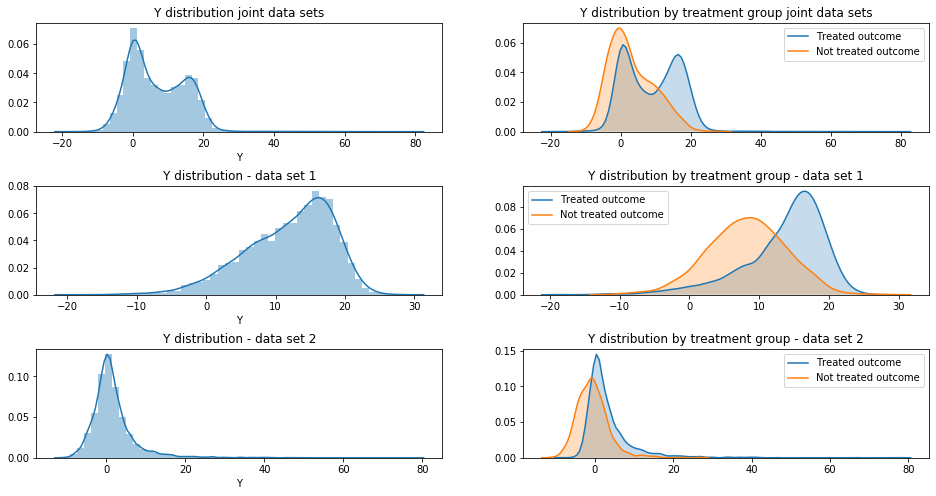

In [62]:
fig, ax = plt.subplots(nrows = 3, ncols=2, figsize=(16,8))
sns.distplot(data.Y, ax=ax[0,0])
ax[0,0].set_title('Y distribution joint data sets')
sns.kdeplot(data[data['T']==1].Y, shade=True, label='Treated outcome', ax=ax[0,1])
sns.kdeplot(data[data['T']==0].Y, shade=True, label='Not treated outcome', ax=ax[0,1])
ax[0,1].set_title('Y distribution by treatment group joint data sets')

sns.distplot(data1.Y, ax=ax[1,0])
ax[1,0].set_title('Y distribution - data set 1')
sns.kdeplot(data1[data1['T']==1].Y, shade=True, label='Treated outcome', ax=ax[1,1])
sns.kdeplot(data1[data1['T']==0].Y, shade=True, label='Not treated outcome', ax=ax[1,1])
ax[1,1].set_title('Y distribution by treatment group - data set 1')

sns.distplot(data2.Y, ax=ax[2,0])
ax[2,0].set_title('Y distribution - data set 2')
sns.kdeplot(data2[data2['T']==1].Y, shade=True, label='Treated outcome', ax=ax[2,1])
sns.kdeplot(data2[data2['T']==0].Y, shade=True, label='Not treated outcome', ax=ax[2,1])
ax[2,1].set_title('Y distribution by treatment group - data set 2')

fig.subplots_adjust(wspace=None, hspace=0.5)

In [63]:
print(f"%{(data[data['T']==1].shape[0]/data.shape[0])*100} of samples got treatment in both data sets")
print(f"%{(data1[data1['T']==1].shape[0]/data1.shape[0])*100} of samples got treatment in data1")
print(f"%{(data2[data2['T']==1].shape[0]/data2.shape[0])*100} of samples got treatment in data2")

%61.422324031653474 of samples got treatment in both data sets
%68.15910037484382 of samples got treatment in data1
%54.685547688463146 of samples got treatment in data2


In [101]:
dummy_data1 = pd.get_dummies(data1[['x_2','x_21','x_24']])
dummy_data1 = dummy_data1.reset_index()
data1_adj = data1.drop(columns=['Unnamed: 0','x_2','x_21','x_24']).reset_index()

dummy_data2 = pd.get_dummies(data2[['x_2','x_21','x_24']])
dummy_data2 = dummy_data2.reset_index()
data2_adj = data2.drop(columns=['Unnamed: 0','x_2','x_21','x_24']).reset_index()

In [113]:
data11 = pd.merge(data1_adj,dummy_data1, on='index')
data21 = pd.merge(data2_adj,dummy_data2, on='index')

In [114]:
print(f"changed 3 categorial features to one hot vectors - adding {dummy_data1.shape[1]-3} columns \ndata now contains {data11.shape[1]} features")

changed 3 categorial features to one hot vectors - adding 25 columns 
data now contains 85 features


In [115]:
data11.drop(columns=['index'],inplace=True)
data21.drop(columns=['index'],inplace=True)

In [117]:
# change categorial columns to one hot vectors

data_cols = data11.drop(columns=['T','Y'])

coefficient_diff = pd.DataFrame()
coefficient_diff['treated_mean'] = data_cols[data11['T']==1].mean()
coefficient_diff['treated_med'] = data_cols[data11['T']==1].median()
coefficient_diff['treated_std'] = data_cols[data11['T']==1].std()
coefficient_diff['not_treated_mean'] = data_cols[data11['T']==0].mean()
coefficient_diff['treated_med'] = data_cols[data11['T']==0].median()
coefficient_diff['not_treated_std'] = data_cols[data11['T']==0].std() 

print("Data 1 diffrence in covariates in treated and non-treated")
coefficient_diff

Data 1 diffrence in covariates in treated and non-treated


,treated_mean,treated_med,treated_std,not_treated_mean,not_treated_std
x_1,25.255118,24.000,5.981481,25.435579,6.055476
x_3,7.206882,0.125,10.199968,7.070471,9.759588
x_4,4.897036,3.000,5.611786,5.098430,5.730501
x_5,63.432631,63.000,2.614808,63.319817,2.579192
x_6,130.624809,126.000,24.808282,130.368869,25.588185
...,...,...,...,...,...
x_24_A,0.003972,0.000,0.062907,0.003270,0.057110
x_24_B,0.260617,0.000,0.439038,0.274689,0.446504
x_24_C,0.002444,0.000,0.049386,0.001308,0.036155
x_24_D,0.010388,0.000,0.101406,0.011772,0.107895


In [118]:
data_cols = data21.drop(columns=['T','Y'])

coefficient_diff = pd.DataFrame()
coefficient_diff['treated_mean'] = data_cols[data21['T']==1].mean()
coefficient_diff['treated_med'] = data_cols[data21['T']==1].median()
coefficient_diff['treated_std'] = data_cols[data21['T']==1].std()
coefficient_diff['not_treated_mean'] = data_cols[data21['T']==0].mean()
coefficient_diff['treated_med'] = data_cols[data21['T']==0].median()
coefficient_diff['not_treated_std'] = data_cols[data21['T']==0].std() 

print("Data 2 diffrence in covariates in treated and non-treated")
coefficient_diff

Data 2 diffrence in covariates in treated and non-treated


,treated_mean,treated_med,treated_std,not_treated_mean,not_treated_std
x_1,25.296268,24.0,6.093541,25.332261,5.897936
x_3,6.862767,0.5,9.832595,7.526310,10.320579
x_4,4.849581,3.0,5.574776,5.095818,5.737947
x_5,62.838538,64.0,2.556302,64.070312,2.499677
x_6,127.237243,130.0,24.575010,134.533088,25.057448
...,...,...,...,...,...
x_24_A,0.004950,0.0,0.070199,0.002298,0.047891
x_24_B,0.257426,0.0,0.437299,0.274357,0.446292
x_24_C,0.001523,0.0,0.039006,0.002757,0.052450
x_24_D,0.011043,0.0,0.104526,0.010570,0.102289


# Propensetiy Methods
I will try different estimation of the propensity scores:
<br> 1) Logistic regression
<br> 2) Gradient boosted decision trees
<br> 3) Neural Network
<br> 4)

In [153]:
def calc_propensity_score_sklearn_LR(X,T):

    model = LogisticRegression(max_iter=500)
    ps_model = model.fit(X=X, y=T)
    pscores = ps_model.predict_proba(X)[:,1]

    return ps_model, pscores



def plot_pscores(datasets, titles=['propensity score of data1','propensity score of data2']):
    ncols = len(datasets)
    fig, ax = plt.subplots(nrows=1,ncols=ncols, figsize=plt.figaspect(0.5))
    for i, data in enumerate(datasets):      
        labels = [0,1]
        data_0 = data[data['T']==0]
        data_1 = data[data['T']==1]
        N_0 = data_0.shape[0]
        N_1 = data_1.shape[0]
        
        pscores_treated = data_1.ps
        ax[i] = sns.kdeplot(pscores_treated, shade=True, label=f'T={labels[1]} N=({N_1})', ax=ax[i])
        pscores_not_treated = data_0.ps
        ax[i] = sns.kdeplot(pscores_not_treated, shade=True, label=f'T={labels[0]} N=({N_0})', ax=ax[i])
        ax[i].set_title(titles[i])
        ax[i].legend(loc="best")

In [154]:
cols_to_drop = ['T','Y']
data1_cov = data11.drop(columns=cols_to_drop)
data2_cov = data21.drop(columns=cols_to_drop)

In [155]:

ps_model1, pscores = calc_propensity_score_sklearn_LR(X=data1_cov, T=data11['T'])
data1_copy = data11.copy()
data1_copy['ps'] = pscores


ps_model2, pscores = calc_propensity_score_sklearn_LR(X=data2_cov, T=data21['T'])
data2_copy = data2.copy()
data2_copy['ps'] = pscores


/Users/amirgavrieli/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/amirgavrieli/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

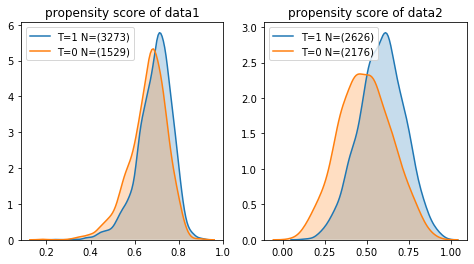

In [156]:
plot_pscores(datasets=[data1_copy,data2_copy])

# Matching 

In [157]:
def find_propensity_score_matches(X, TX_col, pscore_col, caliper=0.25, distance='linear'):
    """
    Treatment group should be smaller
    """
    
    idx_A0 = X[TX_col]==0
    idx_A1 = X[TX_col]==1
    
    X_T1, X_T0 = X[idx_A1].copy(), X[idx_A0].copy()
    N1, N0 = len(X_T1), len(X_T0)
    g1, g0 = X_T1.loc[:,pscore_col].copy(),  X_T0.loc[:,pscore_col].copy()
    
    # get caliper_value (default is 0.25 logit stdevs
    caliper_value = caliper * logit(X[pscore_col]).std()

    # Randomly permute the smaller group to get order for matching
    g1_idx_order = np.random.permutation(g1.index)
    for g1_idx in g1_idx_order:
        
        if distance=='linear': # linear propensity score (on the logits)
            dist = np.abs(logit(g1[g1_idx]) - logit(g0))
        else: # regular propensity score
            dist = np.abs(g1[g1_idx] - g0)
        
        
        if dist.min() <= caliper_value:
            g0_idx = dist.idxmin()
            X_T1.loc[g1_idx, 'matched_control_idx'] = g0_idx
            X_T0.loc[g0_idx, 'matched_control_idx'] = g0_idx
            g0 = g0.drop(g0_idx)
        else:
            X_T1.loc[g1_idx, 'matched_control_idx'] = np.nan        
            
    X_matched = pd.concat([X_T1, X_T0])
    return X_matched

In [158]:
data11['ps'] = data1_copy.ps
data_matched = find_propensity_score_matches(data11, 'T', 'ps', caliper=0.25, distance='linear')

In [159]:
data_matched.dropna(subset=['matched_control_idx'],inplace=True)

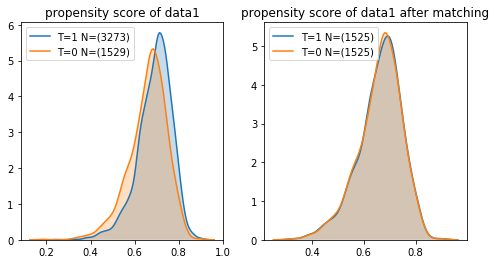

In [160]:
plot_pscores(datasets=[data11,data_matched],titles=['propensity score of data1','propensity score of data1 after matching'])

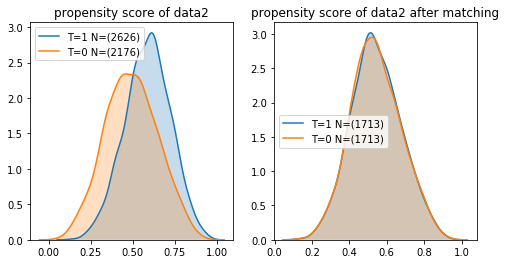

In [161]:
data21['ps'] = data2_copy.ps
data_matched2 = find_propensity_score_matches(data21, 'T', 'ps', caliper=0.25, distance='linear')
data_matched2.dropna(subset=['matched_control_idx'],inplace=True)
plot_pscores(datasets=[data21,data_matched2],titles=['propensity score of data2','propensity score of data2 after matching'])


# Estimating ATT by Inverse Propensity Score Weighting (IPW)

Under ignorability ATE=ATT. And we use the following formula:
\begin{equation}
\frac{1}{n}\sum_{i=1}^{n}{\frac{y_i t_i}{e_i}} - \frac{1}{n}\sum_{i=1}^{n}{\frac{y_i (1-t_i)}{1-e_i}}
\end{equation}


In [145]:
ATT1 = (data11.Y*data11['T']*(1/data1_copy.ps)).mean() - (data11.Y*(1-data11['T'])*(1/(1-data1_copy.ps))).mean()
print(f"The estimated ATT for data1 using IPW is {ATT1}")

The estimated ATT for data1 using IPW is 4.508278610497134


In [146]:
ATT2 = (data21.Y*data21['T']*(1/data2_copy.ps)).mean() - (data21.Y*(1-data21['T'])*(1/(1-data2_copy.ps))).mean()
print(f"The estimated ATT for data1 using IPW is {ATT2}")

The estimated ATT for data1 using IPW is 3.4260361883900963


# Estimating ATT using S-Learner

S-learner (single): fit a model with $t$ as feature on the entire sample:
\begin{equation}
y \approx \hat{f}(x,t) \\
ATT \approx \frac{1}{n}\sum_{i=1}^{n}{\hat{f}(x,1)} - \frac{1}{n}\sum_{i=1}^{n}{\hat{f}(x,0)}
\end{equation}

## S-Learner a linear approach

In [169]:
model = LinearRegression()
X = data11.drop(columns=['Y','ps'])
y = data11['Y']               
reg1 = model.fit(X,y)

In [171]:
X_1 = X.copy()
X_1['T'] = 1
X_0 = X.copy()
X_0['T'] = 0       
ATT1 = (reg1.predict(X_1) - reg1.predict(X_0)).mean()
print(f"The estimated ATT for data1 using S-Learner is {ATT1}")

The estimated ATT for data1 using S-Learner is 4.635642018972905


In [173]:
X = data21.drop(columns=['Y','ps'])
y = data21['Y']               
reg2 = model.fit(X,y)

In [174]:
X_1 = X.copy()
X_1['T'] = 1
X_0 = X.copy()
X_0['T'] = 0       
ATT2 = (reg2.predict(X_1) - reg2.predict(X_0)).mean()
print(f"The estimated ATT for data1 using S-Learner is {ATT2}")

The estimated ATT for data1 using S-Learner is 3.123800637335524


# S-Learner Tree